## Create vocab to train the models

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme(color_codes=True)
from PIL import Image
import os
import sys

from transformers.utils import logging

logging.set_verbosity(transformers.logging.ERROR) 
logging.disable_progress_bar() 

p = os.path.abspath('../')
sys.path.insert(1, p)

from torchtext.vocab import build_vocab_from_iterator

import evaluate
import math
import copy

from collections import defaultdict

import random
import torchvision
from datasets import Image
from src.utils.utils import *

import os
from datasets import Dataset
from datasets import load_dataset
from datasets import Features, Value
from src.wordnet_ontology.wordnet_ontology import *

seed=7631
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

%load_ext autoreload
%autoreload 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mapping_filename = './data/external/imagenet/LOC_synset_mapping.txt'
wn = WordnetOntology(mapping_filename)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preparing datasets

Found cached dataset imagenet_sketch (/mnt/HDD/kevinds/sketch/./cache/imagenet_sketch/default/0.0.0/9bbda26372327ae1daa792112c8bbd2545a91b9f397ea6f285576add0a70ab6e)


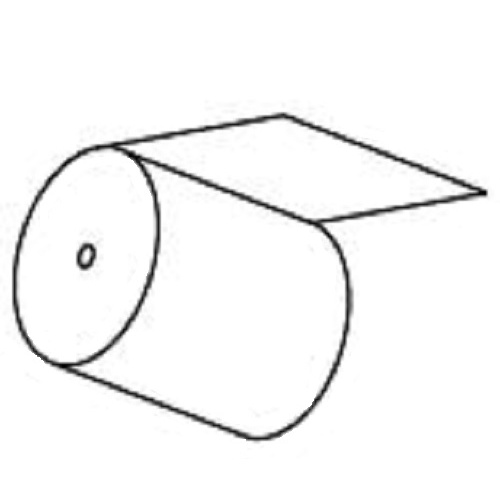

In [14]:
sketch = load_dataset("imagenet_sketch", split='train', cache_dir='./cache/')
sketch = sketch.cast_column('image', Image(decode=False))

img = PIL.Image.open(sketch[1]['image']['path'])
display(img)

In [15]:
_class = wn.class_for_index[sketch[1]['label']]
print(f"class: {_class}, ({wn.class_name(_class)})")
print(f"hclass: {wn.hypernym(_class)}, ({wn.class_name(wn.hypernym(_class))})")

class: n03887697, (paper towel)
hclass: n04459362, (towel)


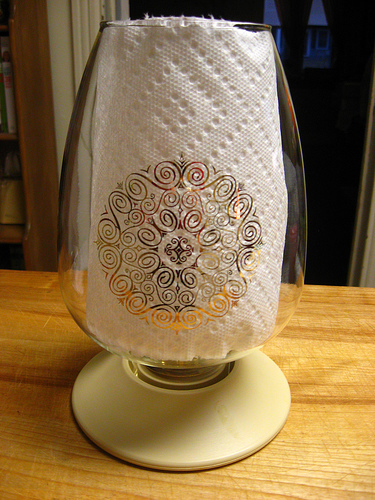

In [16]:
_cls = os.listdir('./data/external/imagenet/ILSVRC/Data/CLS-LOC/train/n03887697')
_img = PIL.Image.open('./data/external/imagenet/ILSVRC/Data/CLS-LOC/train/n03887697/' + random.choice(_cls))
_img

In [17]:
imagenet_classes_folder = './data/external/imagenet/ILSVRC/Data/CLS-LOC/train'

image_labels = [] 
image_paths = []

N_IMAGENET_EXAMPLES = 100
imagenet_classes = sorted(os.listdir(imagenet_classes_folder))
for img_class in imagenet_classes:
    all_imgs = os.listdir(f"{imagenet_classes_folder}/{img_class}/")
    img_names = [random.choice(all_imgs) for _ in range(0, N_IMAGENET_EXAMPLES)]
                              
    image_paths.extend([f"{imagenet_classes_folder}/{img_class}/{name}" for name in img_names])
    image_labels.extend([img_class] * len(img_names))

In [18]:
def get_image_path(row):
    return {'path': row['image']['path']}

sketch = sketch.map(get_image_path, remove_columns=['image'])

Loading cached processed dataset at /mnt/HDD/kevinds/sketch/./cache/imagenet_sketch/default/0.0.0/9bbda26372327ae1daa792112c8bbd2545a91b9f397ea6f285576add0a70ab6e/cache-31d3fbb8dae0a5a5.arrow


In [19]:
sketch = sketch.map(lambda x: {'class': wn.class_for_index[x['label']]})

Loading cached processed dataset at /mnt/HDD/kevinds/sketch/./cache/imagenet_sketch/default/0.0.0/9bbda26372327ae1daa792112c8bbd2545a91b9f397ea6f285576add0a70ab6e/cache-48d2d957ba26910a.arrow


In [20]:
classes = set([wn.hypernym(cl) for cl in sketch['class']])
pt_vocab = build_vocab_from_iterator([classes])
NUM_CLASSES = len(pt_vocab)
def get_hclass(x):
    hclass = wn.hypernym(x['class'])
    return { 
        'hclass': hclass,
        'label': pt_vocab[hclass] 
    }

sketch = sketch.map(get_hclass, remove_columns=['class'])

Loading cached processed dataset at /mnt/HDD/kevinds/sketch/./cache/imagenet_sketch/default/0.0.0/9bbda26372327ae1daa792112c8bbd2545a91b9f397ea6f285576add0a70ab6e/cache-e7cfd63262604e61.arrow


In [21]:
sketch[50]

{'label': 474,
 'path': './cache/downloads/extracted/b7724a58d90ea10a91b65f4b29c5ddf0c5b8980a595022f2fd0ffd028234ad30/sketch/n03887697/sketch_45.JPEG',
 'hclass': 'n04459362'}

In [22]:
len(pt_vocab)

556

In [11]:
#torch.save(pt_vocab, './models/vocab.pt')
#vocab = torch.load('./models/vocab.pt')